In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
data = pd.read_csv('/content/drive/MyDrive/PTSD /PTSD_final.csv')

# Data Wrangling



In [189]:
### test_1 is the first machine learning experiment
test_1 = data.copy()
# test_1.drop(columns=['freezing_recall5','date_recall5','dob','date_sefla','Unnamed: 0'], inplace = True)
test_1_sefl = test_1[test_1['condition']=='sefl']
test_1_sefl = test_1_sefl.drop(['condition','Unnamed: 0'], axis=1)
# sex=1 male; sex=0, female
# age=1 old(days from dob to sefla >84 days); age=0 young(days from dob to sefla <= 84days)
test_1_sefl['sex'] = test_1_sefl['sex'].replace({'male': 1, 'female': 0})
test_1_sefl['age_selfa'].astype(int)
test_1_sefl['age_selfa'] = (test_1_sefl['age_selfa'] > 84).astype(int)
test_1_sefl = test_1_sefl.drop(columns = ['dob','date_sefla'])

# Visualization Part

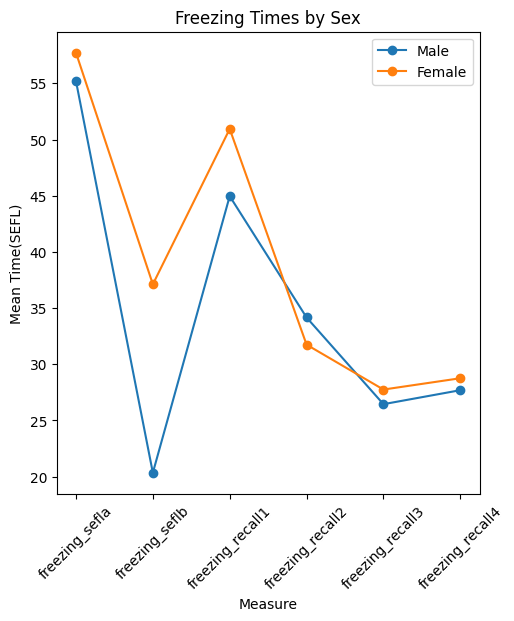

In [190]:
df = test_1_sefl.copy()
# Recalculating with inclusion of freezing sefla and freezing seflb
# For both sex and age groups
# Adding to the original calculation for comparison

# Recalculate means for sex categories
male_means = df[df['sex'] == 1][['freezing_sefla', 'freezing_seflb', 'freezing_recall1', 'freezing_recall2', 'freezing_recall3', 'freezing_recall4']].mean()
female_means = df[df['sex'] == 0][['freezing_sefla', 'freezing_seflb', 'freezing_recall1', 'freezing_recall2', 'freezing_recall3', 'freezing_recall4']].mean()

# Plotting
plt.figure(figsize=(12, 6))

# Sex
plt.subplot(1, 2, 2)
plt.plot(male_means.index, male_means.values, label='Male', marker='o')
plt.plot(female_means.index, female_means.values, label='Female', marker='o')
plt.title('Freezing Times by Sex')
plt.xlabel('Measure')
plt.ylabel('Mean Time(SEFL)')
plt.xticks(rotation=45)
plt.legend()

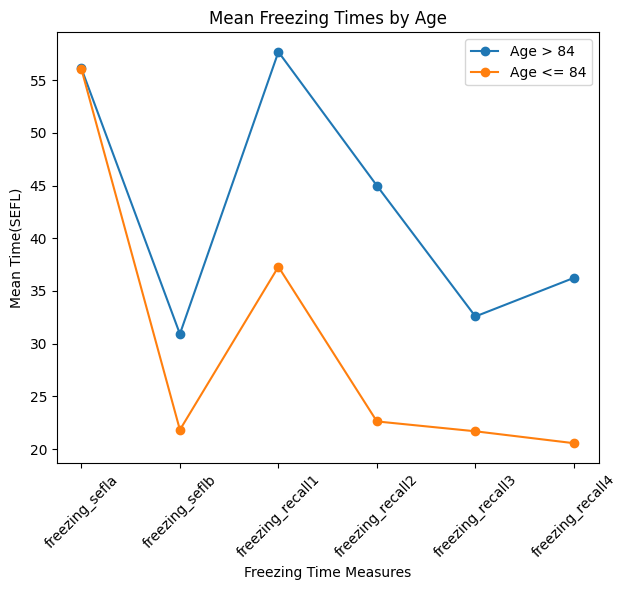

In [191]:
# Calculating mean freezing times for age above 84 and below or equal to 100
age_above_84_means = df[df['age_selfa']==1][['freezing_sefla', 'freezing_seflb', 'freezing_recall1', 'freezing_recall2', 'freezing_recall3', 'freezing_recall4']].mean()
age_below_84_means = df[df['age_selfa']==0][['freezing_sefla', 'freezing_seflb', 'freezing_recall1', 'freezing_recall2', 'freezing_recall3', 'freezing_recall4']].mean()
# Plotting
plt.figure(figsize=(12, 6))
# Plot for age
plt.subplot(1, 2, 2)
plt.plot(age_above_84_means, label='Age > 84', marker='o')
plt.plot(age_below_84_means, label='Age <= 84', marker='o')
plt.title('Mean Freezing Times by Age')
plt.xlabel('Freezing Time Measures')
plt.ylabel('Mean Time(SEFL)')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# SEFL Group


## Training without Learning curve

In [192]:
test_1_sefl = test_1_sefl.drop(columns = ['freezing_recall5','date_recall5'])

In [193]:
from sklearn.model_selection import train_test_split
X = test_1_sefl.drop(columns = ['cohort_id','date_recall1','freezing_recall4'])
y = test_1_sefl['freezing_recall4']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [194]:
import random
random.seed(12)

###OLS

In [195]:
import statsmodels.api as sm

# Adding a constant to the X_train and X_test for the intercept term
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Creating the model
ols_model = sm.OLS(y_train, X_train_sm)

# Fitting the model
ols_results = ols_model.fit()

# Calculate MSE for training data
y_train_pred = ols_results.predict(X_train_sm)
mse_train = sm.tools.eval_measures.mse(y_train, y_train_pred)

# Calculate MSE for test data
y_test_pred = ols_results.predict(X_test_sm)
mse_test = sm.tools.eval_measures.mse(y_test, y_test_pred)

# Getting a summary of the model
ols_summary = ols_results.summary()
ols_summary, mse_train, mse_test

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:       freezing_recall4   R-squared:                       0.404
 Model:                            OLS   Adj. R-squared:                  0.166
 Method:                 Least Squares   F-statistic:                     1.697
 Date:                Thu, 11 Apr 2024   Prob (F-statistic):              0.137
 Time:                        03:54:54   Log-Likelihood:                -134.64
 No. Observations:                  36   AIC:                             291.3
 Df Residuals:                      25   BIC:                             308.7
 Df Model:                          10                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [196]:
# Initialize an empty list to store MSE values and their corresponding identifiers
mse_list = []

mse_sefl_without_test = sm.tools.eval_measures.mse(y_test, y_test_pred)

# Dictionary for the first model's MSE and identifiers
mse_sefl_without = {
    'name': 'SEFL_WITHOUT',  # Model or group name
    'method': 'OLS',       # Method used
    'mse': mse_sefl_without_test  # Calculated MSE
}

# Append this dictionary to the list
mse_list.append(mse_sefl_without)

In [197]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import numpy as np

# Fit OLS model
ols_model = OLS(y_train, sm.add_constant(X_train)).fit()

# Get OLS predictions for the test set
y_pred_ols = ols_model.predict(sm.add_constant(X_test))

# Get standard errors of predictions
pred_stderr = ols_model.get_prediction(sm.add_constant(X_test)).se_obs

# Calculate the 95% confidence interval for the predictions
ci_lower = y_pred_ols - 1.96 * pred_stderr
ci_upper = y_pred_ols + 1.96 * pred_stderr

# Checking how many of the actual test values fall within the 95% confidence interval
inside_ci = np.sum((y_test >= ci_lower) & (y_test <= ci_upper))
percentage_inside_ci = (inside_ci / len(y_test)) * 100

percentage_inside_ci

100.0

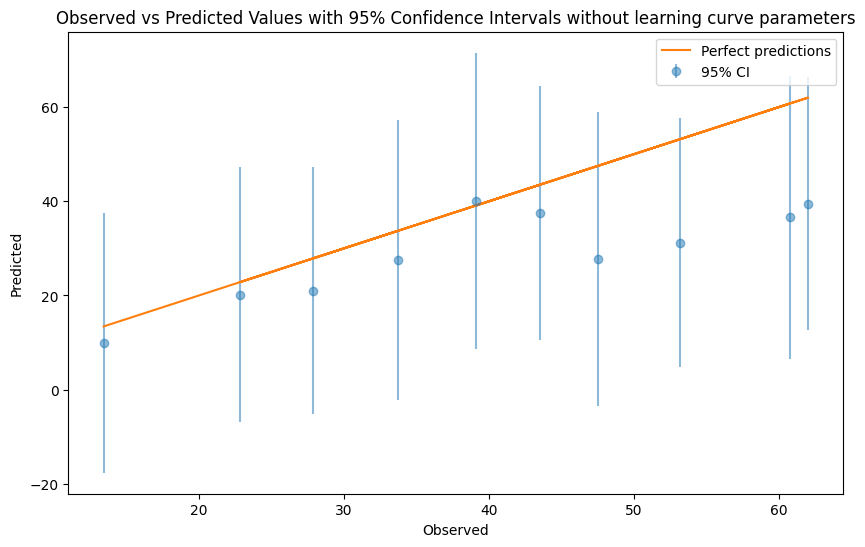

In [198]:
# Visualize the outcomes
plt.figure(figsize=(10, 6))

# Plot the observed vs predicted values with confidence intervals
plt.errorbar(y_test, y_pred_ols, yerr=1.96*pred_stderr, fmt='o', alpha=0.5, label='95% CI')

# Plot a line for perfect predictions
plt.plot(y_test, y_test, label='Perfect predictions')

# Labelling
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs Predicted Values with 95% Confidence Intervals without learning curve parameters')
plt.legend()
plt.show()

### Machine Learning Methods

In [199]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}


model_mse = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring=mse_scorer)
    mean_score = -np.mean(scores)
    model_mse[model_name] = mean_score

model_mse

{'Decision Tree Regressor': 274.90753911111113,
 'Random Forest Regressor': 174.73449897402233,
 'Gradient Boosting Regressor': 214.13162446689512}

In [200]:
model_importances = {}
mse_details = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features_importance = dict(zip(X.columns, importances))
        sorted_importances = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)
        model_importances[model_name] = sorted_importances
    else:
        model_importances[model_name] = "This model doesn't support feature importance."
        # Append to mse_list with the specified structure
    mse_entry = {
        'name': "SEFL_WITHOUT",  # Combine "SEFL_WITHOUT" with the model name
        'method': model_name,  # You might adjust this as needed
        'mse': test_mse
    }
    mse_list.append(mse_entry)


    mse_details[model_name] = {"Train MSE": train_mse, "Test MSE": test_mse}

for model_name, importances in model_importances.items():
    mse_info = mse_details[model_name]
    print(f"{model_name} MSE:")
    print(f"Train MSE: {mse_info['Train MSE']}")
    print(f"Test MSE: {mse_info['Test MSE']}\n")
    print(f"{model_name} feature importances:")
    for feature, importance in importances:
        print(f"{feature}: {importance}")
    print("\n")

Decision Tree Regressor MSE:
Train MSE: 0.0
Test MSE: 248.61930000000012

Decision Tree Regressor feature importances:
freezing_recall1: 0.3788881374368468
freezing_sefla: 0.2226241563039454
freezing_recall3: 0.15826155329191924
date_recall4: 0.09631142031842592
freezing_seflb: 0.09441337321020349
freezing_recall2: 0.04646221644494016
date_recall2: 0.002842421951979512
sex: 0.00015186491219287764
date_recall3: 4.485612954657435e-05
date_seflb: 0.0
age_selfa: 0.0


Random Forest Regressor MSE:
Train MSE: 27.190311564722197
Test MSE: 252.83501426400034

Random Forest Regressor feature importances:
freezing_recall3: 0.2578697150351462
freezing_recall1: 0.2570906404816611
freezing_sefla: 0.21914304446968785
freezing_seflb: 0.09541484455815778
freezing_recall2: 0.09310738498728709
date_recall4: 0.03835416884705304
age_selfa: 0.015086934565715089
sex: 0.009566636344385048
date_recall2: 0.00817153046234122
date_recall3: 0.0061951002485656805
date_seflb: 0.0


Gradient Boosting Regressor MSE:


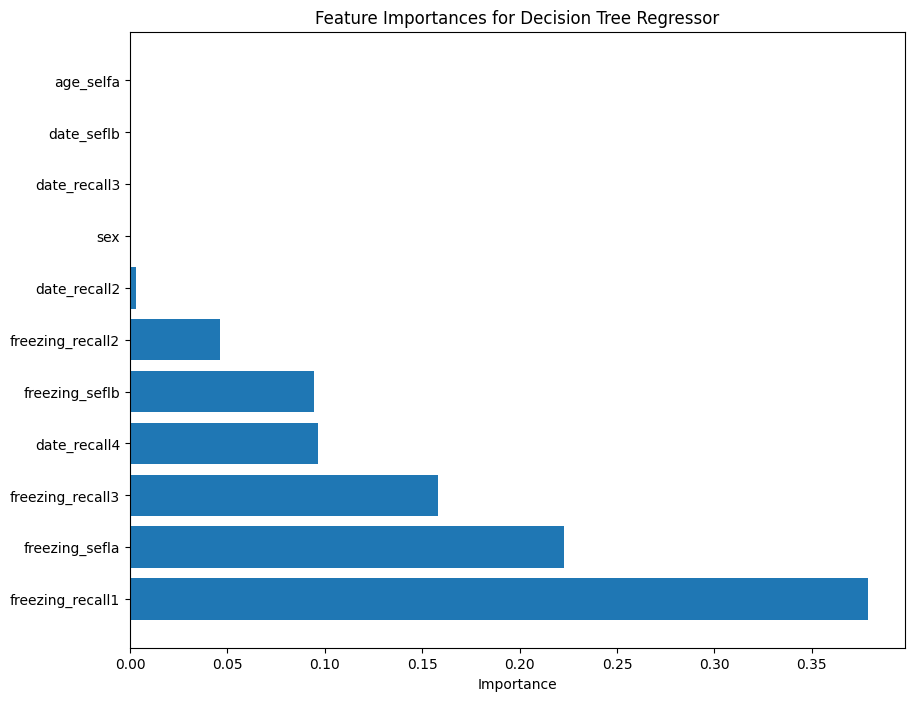

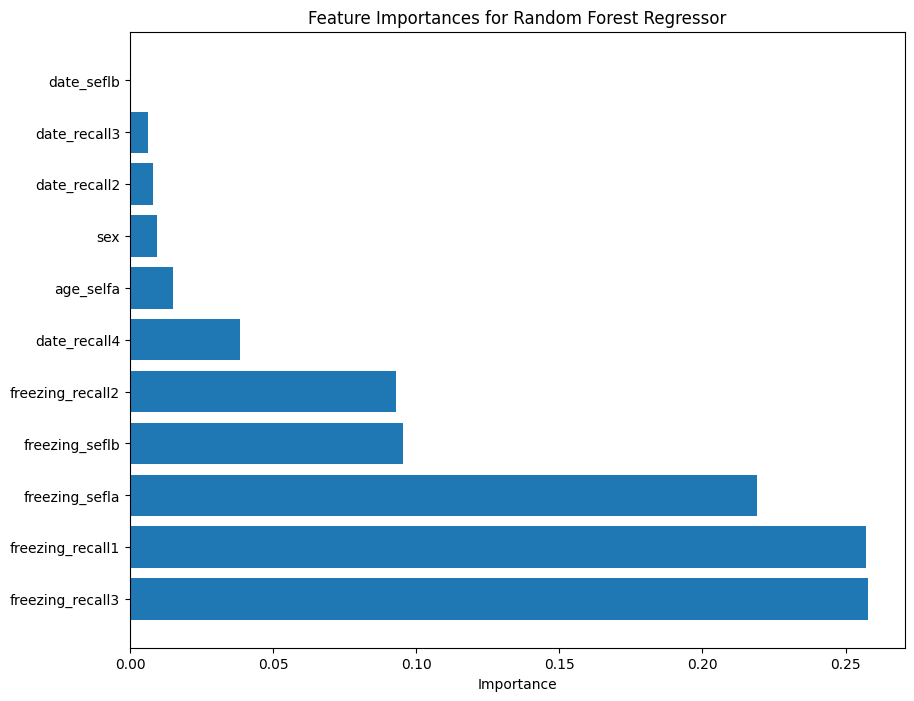

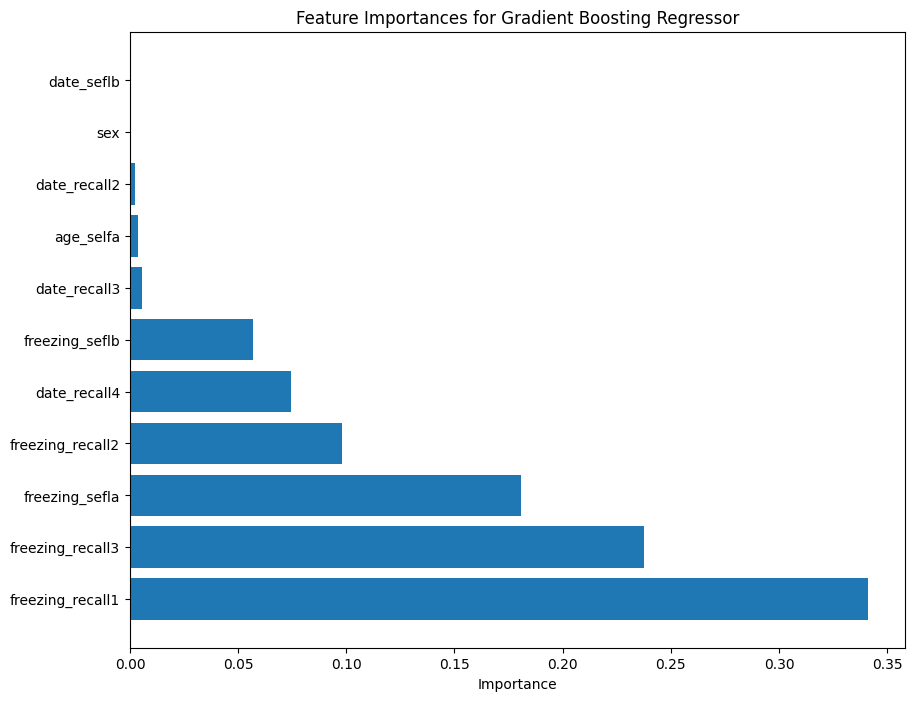

In [201]:
# Assuming model_importances is populated as per your code
for model_name, importances in model_importances.items():
    # Check if the model supports feature importances
    if isinstance(importances, str):
        print(f"{model_name} does not support feature importance.")
        continue

    # Unpacking the features and their importances
    features, importances = zip(*importances)

    # Creating the plot
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importances)), importances, align='center')
    plt.yticks(range(len(importances)), features)
    plt.xlabel('Importance')
    plt.title(f'Feature Importances for {model_name}')

    plt.show()

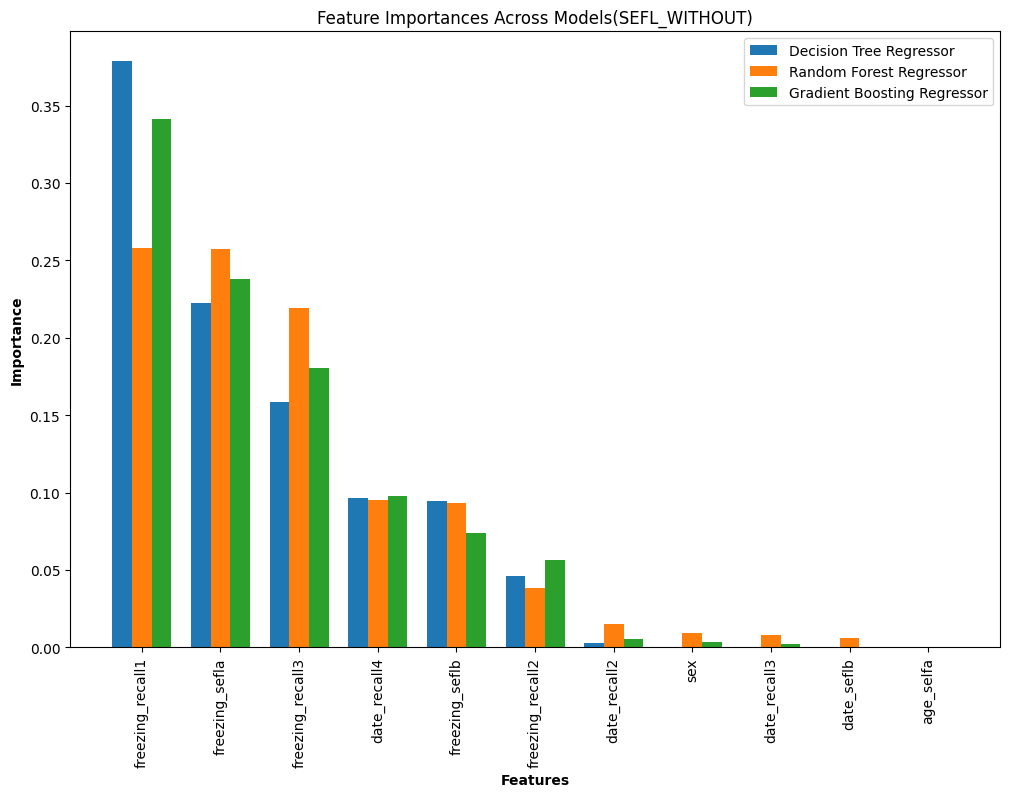

In [202]:
# Filter out models that don't support feature importance
valid_importances = {model: features for model, features in model_importances.items() if not isinstance(features, str)}

# Assuming all models have the same number and order of features, which should be ensured beforehand
feature_names = [feature for feature, _ in next(iter(valid_importances.values()))]

# Number of models and features
n_models = len(valid_importances)
n_features = len(feature_names)

# Creating a bar width and positions
barWidth = 1 / (n_models + 1)
positions = np.arange(n_features)

# Create figure and axis
plt.figure(figsize=(12, 8))

for i, (model_name, importances) in enumerate(valid_importances.items()):
    # Assuming the order of features is consistent across models, extract just the importances
    feature_importances = [importance for _, importance in importances]
    # Calculate position for each bar
    barPositions = [x + (i * barWidth) for x in positions]

    # Plot
    plt.bar(barPositions, feature_importances, width=barWidth, label=model_name)

# Adding labels and title
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Importance', fontweight='bold')
plt.title('Feature Importances Across Models(SEFL_WITHOUT)')

# Adding ticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(n_features)], feature_names, rotation=90)

# Create legend & Show graphic
plt.legend()
plt.show()

In [203]:
# Training the RandomForestRegressor with the actual dataset provided by the user
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicting the target variable for the test set using the random forest
y_pred_rf = rf.predict(X_test)

# Initialize the list to store prediction intervals
y_pred_intervals_rf = []

# Calculate the prediction interval for each test example
for i in range(len(X_test)):
    # Get the predictions from each tree
    predictions = [tree.predict(X_test.iloc[i].values.reshape(1, -1)) for tree in rf.estimators_]

    # Calculate the 2.5th and 97.5th percentiles for the predictions
    lower_bound = np.percentile(predictions, 2.5)
    upper_bound = np.percentile(predictions, 97.5)
    y_pred_intervals_rf.append((lower_bound, upper_bound))

# Convert prediction intervals to a numpy array for easier manipulation
y_pred_intervals_rf = np.array(y_pred_intervals_rf)

# Calculate the percentage of test set targets that fall within the prediction intervals
within_interval = np.sum((y_test >= y_pred_intervals_rf[:, 0]) & (y_test <= y_pred_intervals_rf[:, 1]))
interval_coverage = within_interval / len(y_test) * 100

interval_coverage

70.0

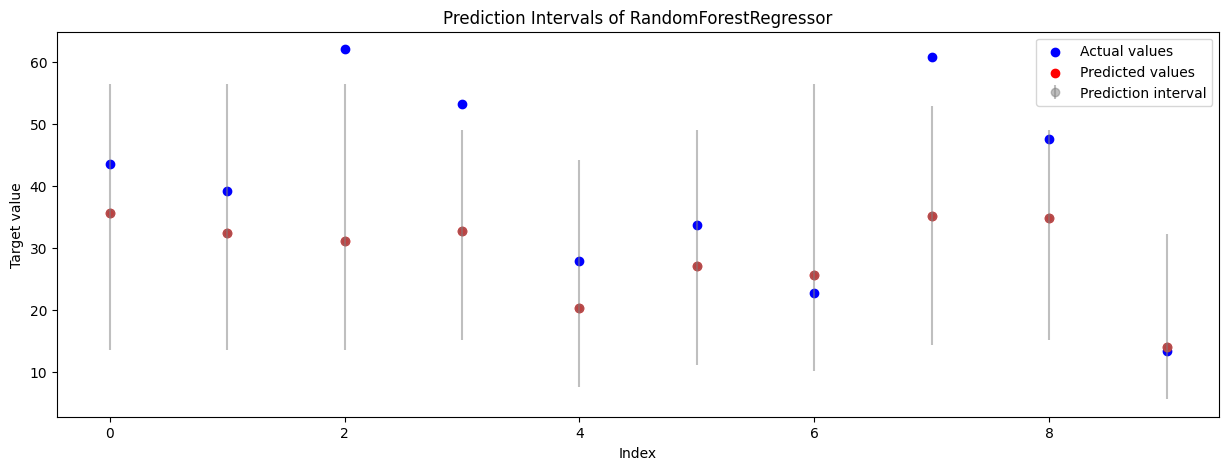

In [204]:
# Plot the predicted values and the prediction intervals
plt.figure(figsize=(15, 5))

# Index for x-axis
index = np.arange(len(y_test))

# Plotting the actual values
plt.scatter(index, y_test, color='blue', label='Actual values')

# Plotting the predicted values
plt.scatter(index, y_pred_rf, color='red', label='Predicted values')

# Plotting the prediction intervals
plt.errorbar(index, y_pred_rf, yerr=[y_pred_rf - y_pred_intervals_rf[:, 0], y_pred_intervals_rf[:, 1] - y_pred_rf],
             fmt='o', color='gray', alpha=0.5, label='Prediction interval')

plt.title('Prediction Intervals of RandomForestRegressor')
plt.xlabel('Index')
plt.ylabel('Target value')
plt.legend()

## Training with learning curve(mean)


### Wrangling

In [205]:
df_lc = pd.read_csv('/content/drive/MyDrive/PTSD /stim_interval_freezing.csv')
df_lc = df_lc.dropna(axis=0)

In [206]:
df_lc['cohort_id'] = df_lc['Cohort'] + '_' + df_lc['id']

# Calculate the mean of Shock01 to Shock10 for each row
shock_columns = [f'Shock0{i}' if i < 10 else f'Shock{i}' for i in range(1, 11)]
df_lc['mean_shock'] = df_lc[shock_columns].mean(axis=1)

# Display the first few rows of the updated dataframe to verify the changes
df_mean_lc = df_lc[['cohort_id', 'mean_shock']]

In [207]:
test_mean_lc = test_1_sefl.merge(df_mean_lc, on='cohort_id', how='inner')

### OLS

In [208]:
X = test_mean_lc.drop(columns = ['cohort_id','date_recall1','freezing_recall4'])
y = test_mean_lc['freezing_recall4']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
# Adding a constant to the X_train and X_test for the intercept term
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Creating the model
ols_model = sm.OLS(y_train, X_train_sm)

# Fitting the model
ols_results = ols_model.fit()

# Calculate MSE for training data
y_train_pred = ols_results.predict(X_train_sm)
mse_train = sm.tools.eval_measures.mse(y_train, y_train_pred)

# Calculate MSE for test data
y_test_pred = ols_results.predict(X_test_sm)
mse_test = sm.tools.eval_measures.mse(y_test, y_test_pred)

# Getting a summary of the model
ols_summary = ols_results.summary()
ols_summary, mse_train, mse_test

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:       freezing_recall4   R-squared:                       0.605
 Model:                            OLS   Adj. R-squared:                  0.424
 Method:                 Least Squares   F-statistic:                     3.342
 Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00650
 Time:                        03:54:58   Log-Likelihood:                -128.05
 No. Observations:                  36   AIC:                             280.1
 Df Residuals:                      24   BIC:                             299.1
 Df Model:                          11                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [210]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import numpy as np

# Fit OLS model
ols_model = OLS(y_train, sm.add_constant(X_train)).fit()

# Get OLS predictions for the test set
y_pred_ols = ols_model.predict(sm.add_constant(X_test))

# Get standard errors of predictions
pred_stderr = ols_model.get_prediction(sm.add_constant(X_test)).se_obs

# Calculate the 95% confidence interval for the predictions
ci_lower = y_pred_ols - 1.96 * pred_stderr
ci_upper = y_pred_ols + 1.96 * pred_stderr

# Checking how many of the actual test values fall within the 95% confidence interval
inside_ci = np.sum((y_test >= ci_lower) & (y_test <= ci_upper))
percentage_inside_ci = (inside_ci / len(y_test)) * 100

percentage_inside_ci

55.55555555555556

### Machine Learning Methods

In [211]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}


model_mse = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring=mse_scorer)
    mean_score = -np.mean(scores)
    model_mse[model_name] = mean_score

model_mse

{'Decision Tree Regressor': 251.4776644444445,
 'Random Forest Regressor': 176.0354820571112,
 'Gradient Boosting Regressor': 213.38597143947263}

In [212]:
model_importances = {}
mse_details = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features_importance = dict(zip(X.columns, importances))
        sorted_importances = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)
        model_importances[model_name] = sorted_importances
    else:
        model_importances[model_name] = "This model doesn't support feature importance."

    mse_details[model_name] = {"Train MSE": train_mse, "Test MSE": test_mse}

for model_name, importances in model_importances.items():
    mse_info = mse_details[model_name]
    print(f"{model_name} MSE:")
    print(f"Train MSE: {mse_info['Train MSE']}")
    print(f"Test MSE: {mse_info['Test MSE']}\n")
    print(f"{model_name} feature importances:")
    for feature, importance in importances:
        print(f"{feature}: {importance}")
    print("\n")

Decision Tree Regressor MSE:
Train MSE: 0.0
Test MSE: 329.6332444444445

Decision Tree Regressor feature importances:
freezing_recall3: 0.6930218455955853
date_recall3: 0.12504268573991253
mean_shock: 0.07291562063498369
freezing_seflb: 0.04166277839825781
freezing_recall1: 0.03214028304475434
freezing_recall2: 0.022735386127059054
freezing_sefla: 0.006029159833726699
date_recall4: 0.003984779658704028
age_selfa: 0.0023735375952983204
sex: 9.392337171819492e-05
date_seflb: 0.0
date_recall2: 0.0


Random Forest Regressor MSE:
Train MSE: 19.22903613194434
Test MSE: 363.51095580999987

Random Forest Regressor feature importances:
freezing_recall3: 0.4225755482658716
freezing_sefla: 0.13007205530723068
freezing_seflb: 0.10541719263464806
freezing_recall1: 0.09540066315436124
freezing_recall2: 0.07838638321604452
mean_shock: 0.07513790663873307
date_recall2: 0.031173576223918507
date_recall4: 0.024804522698969003
date_recall3: 0.018626088076438996
age_selfa: 0.015158353881147566
sex: 0.0032

In [213]:
# Training the RandomForestRegressor with the actual dataset provided by the user
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicting the target variable for the test set using the random forest
y_pred_rf = rf.predict(X_test)

# Initialize the list to store prediction intervals
y_pred_intervals_rf = []

# Calculate the prediction interval for each test example
for i in range(len(X_test)):
    # Get the predictions from each tree
    predictions = [tree.predict(X_test.iloc[i].values.reshape(1, -1)) for tree in rf.estimators_]

    # Calculate the 2.5th and 97.5th percentiles for the predictions
    lower_bound = np.percentile(predictions, 2.5)
    upper_bound = np.percentile(predictions, 97.5)
    y_pred_intervals_rf.append((lower_bound, upper_bound))

# Convert prediction intervals to a numpy array for easier manipulation
y_pred_intervals_rf = np.array(y_pred_intervals_rf)

# Calculate the percentage of test set targets that fall within the prediction intervals
within_interval = np.sum((y_test >= y_pred_intervals_rf[:, 0]) & (y_test <= y_pred_intervals_rf[:, 1]))
interval_coverage = within_interval / len(y_test) * 100

interval_coverage

66.66666666666666

##Training with learning curve, every columns of it

In [214]:
df_all_lc = df_lc[['cohort_id']+shock_columns]
test_all_lc = test_1_sefl.merge(df_all_lc, on='cohort_id', how='inner')

In [215]:
test_all_lc.to_csv('/content/drive/My Drive/PTSD /test_all_lc.csv', index=False)

In [216]:
X = test_all_lc.drop(columns = ['cohort_id','date_recall1','freezing_recall4'])
y = test_all_lc['freezing_recall4']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### OLS

In [217]:
# Adding a constant to the X_train and X_test for the intercept term
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Creating the model
ols_model = sm.OLS(y_train, X_train_sm)

# Fitting the model
ols_results = ols_model.fit()

# Calculate MSE for training data
y_train_pred = ols_results.predict(X_train_sm)
mse_train = sm.tools.eval_measures.mse(y_train, y_train_pred)

# Calculate MSE for test data
y_test_pred = ols_results.predict(X_test_sm)
mse_test = sm.tools.eval_measures.mse(y_test, y_test_pred)

# Getting a summary of the model
ols_summary = ols_results.summary()
ols_summary, mse_train, mse_test

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:       freezing_recall4   R-squared:                       0.836
 Model:                            OLS   Adj. R-squared:                  0.617
 Method:                 Least Squares   F-statistic:                     3.819
 Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00543
 Time:                        03:55:00   Log-Likelihood:                -112.25
 No. Observations:                  36   AIC:                             266.5
 Df Residuals:                      15   BIC:                             299.7
 Df Model:                          20                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [218]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import numpy as np

# Fit OLS model
ols_model = OLS(y_train, sm.add_constant(X_train)).fit()

# Get OLS predictions for the test set
y_pred_ols = ols_model.predict(sm.add_constant(X_test))

# Get standard errors of predictions
pred_stderr = ols_model.get_prediction(sm.add_constant(X_test)).se_obs

# Calculate the 95% confidence interval for the predictions
ci_lower = y_pred_ols - 1.96 * pred_stderr
ci_upper = y_pred_ols + 1.96 * pred_stderr

# Checking how many of the actual test values fall within the 95% confidence interval
inside_ci = np.sum((y_test >= ci_lower) & (y_test <= ci_upper))
percentage_inside_ci = (inside_ci / len(y_test)) * 100

percentage_inside_ci

66.66666666666666

### Machine Learning Methods

In [219]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}


model_mse = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring=mse_scorer)
    mean_score = -np.mean(scores)
    model_mse[model_name] = mean_score

model_mse

{'Decision Tree Regressor': 246.33264,
 'Random Forest Regressor': 160.1835887482222,
 'Gradient Boosting Regressor': 217.21555068646109}

In [220]:
model_importances = {}
mse_details = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features_importance = dict(zip(X.columns, importances))
        sorted_importances = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)
        model_importances[model_name] = sorted_importances
    else:
        model_importances[model_name] = "This model doesn't support feature importance."

    mse_details[model_name] = {"Train MSE": train_mse, "Test MSE": test_mse}

for model_name, importances in model_importances.items():
    mse_info = mse_details[model_name]
    print(f"{model_name} MSE:")
    print(f"Train MSE: {mse_info['Train MSE']}")
    print(f"Test MSE: {mse_info['Test MSE']}\n")
    print(f"{model_name} feature importances:")
    for feature, importance in importances:
        print(f"{feature}: {importance}")
    print("\n")

Decision Tree Regressor MSE:
Train MSE: 0.0
Test MSE: 372.977

Decision Tree Regressor feature importances:
freezing_recall3: 0.4472303282427312
Shock04: 0.1372742344433073
Shock02: 0.13523934893557635
Shock10: 0.05443790435473927
Shock08: 0.05020736687092478
freezing_seflb: 0.04003455432596861
freezing_recall1: 0.0387252643900451
Shock05: 0.037427819822345165
date_recall4: 0.031813963521823446
Shock01: 0.020008211563463874
Shock03: 0.0035862551923411252
freezing_sefla: 0.002377570178987291
freezing_recall2: 0.001400983607214148
Shock09: 0.00023021809379775239
Shock07: 5.97645673460733e-06
date_seflb: 0.0
date_recall2: 0.0
date_recall3: 0.0
sex: 0.0
age_selfa: 0.0
Shock06: 0.0


Random Forest Regressor MSE:
Train MSE: 21.930861306944376
Test MSE: 357.5492204188886

Random Forest Regressor feature importances:
freezing_recall3: 0.3468709709596527
Shock02: 0.12876478446691572
Shock03: 0.09366813001318539
Shock01: 0.07362368297848582
freezing_recall2: 0.057615557160058756
Shock04: 0.04074

In [221]:
# Training the RandomForestRegressor with the actual dataset provided by the user
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicting the target variable for the test set using the random forest
y_pred_rf = rf.predict(X_test)

# Initialize the list to store prediction intervals
y_pred_intervals_rf = []

# Calculate the prediction interval for each test example
for i in range(len(X_test)):
    # Get the predictions from each tree
    predictions = [tree.predict(X_test.iloc[i].values.reshape(1, -1)) for tree in rf.estimators_]

    # Calculate the 2.5th and 97.5th percentiles for the predictions
    lower_bound = np.percentile(predictions, 2.5)
    upper_bound = np.percentile(predictions, 97.5)
    y_pred_intervals_rf.append((lower_bound, upper_bound))

# Convert prediction intervals to a numpy array for easier manipulation
y_pred_intervals_rf = np.array(y_pred_intervals_rf)

# Calculate the percentage of test set targets that fall within the prediction intervals
within_interval = np.sum((y_test >= y_pred_intervals_rf[:, 0]) & (y_test <= y_pred_intervals_rf[:, 1]))
interval_coverage = within_interval / len(y_test) * 100

interval_coverage

77.77777777777779

## Training with learning curve parameters

In [222]:
from sklearn.linear_model import LinearRegression

# Preparing the independent variable (1 to 10)
X_lc = np.array(range(1, 11)).reshape(-1, 1)

# Placeholder for calculated beta_1 values
beta_1_values = []

# Loop through each row to calculate beta_1 for Shock01 to Shock10
for index, row in test_all_lc.iterrows():
    y = row[['Shock01', 'Shock02', 'Shock03', 'Shock04', 'Shock05',
             'Shock06', 'Shock07', 'Shock08', 'Shock09', 'Shock10']].values.reshape(-1, 1)
    model = LinearRegression().fit(X_lc, y)
    beta_1 = model.coef_[0][0]  # Extracting beta_1 (slope)
    beta_1_values.append(beta_1)

# Adding the beta_1 values as a new column to the dataframe
test_all_lc['beta_1'] = beta_1_values

# Dropping the original Shock columns
test_all_lc_para = test_all_lc.drop(columns=['Shock01', 'Shock02', 'Shock03', 'Shock04', 'Shock05',
                                  'Shock06', 'Shock07', 'Shock08', 'Shock09', 'Shock10'])


In [223]:
# Prepare the independent variables (X) by dropping the dependent variable and the identifier
X = test_all_lc_para.drop(columns=['cohort_id', 'freezing_recall4'])
# Adding a constant for the intercept
X = sm.add_constant(X)

# Prepare the dependent variable (y)
y = test_all_lc_para['freezing_recall4']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### OLS

In [224]:
# Perform OLS regression
model = sm.OLS(y, X).fit()

# Get the summary of the regression
model_summary = model.summary()

model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       freezing_recall4   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     3.543
Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00208
Time:                        03:55:02   Log-Likelihood:                -167.64
No. Observations:                  45   AIC:                             361.3
Df Residuals:                      32   BIC:                             384.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
freezing_sefla       0.4885      0.208      2.353      0.025       0.066       0.911
freezing_seflb      -0.0601      0.219     -0.275      0.785      -0.506       0.386
date_seflb           1.4782     16.862      0.088      0.931     -32.868      35.824
freezing_recall1     0.2994      0.141      2.119      0.042       0.012       0.587
date_recall1         4.0018      8.109      0.494      0.625     -12.515      20.519
freezing_recall2    -0.1627      0.227     -0.717      0.478      -0.625       0.299
date_recall2        -5.6386     12.404     -0.455      0.652     -30.904      19.627
freezing_recall3     0.2830      0.253      1.120      0.271      -0.232       0.798
date_recall3         0.4397      2.717      0.162      0.872      -5.095       5.974
date_recall4         1.1314      2.298      0.492      0.626      -3.549       5.811
sex                -11.0763     17.515     -0.632      0.532     -46.753      24.600
age_selfa           11.0441     10.112      1.092      0.283      -9.554      31.642
beta_1              -2.1343      1.235     -1.728      0.094      -4.650       0.382
==============================================================================
Omnibus:                        0.897   Durbin-Watson:                   2.464
Prob(Omnibus):                  0.639   Jarque-Bera (JB):                0.820
Skew:                          -0.020   Prob(JB):                        0.664
Kurtosis:                       2.340   Cond. No.                     1.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [225]:
# Fit OLS model
ols_model = OLS(y_train, sm.add_constant(X_train)).fit()

# Get OLS predictions for the test set
y_pred_ols = ols_model.predict(sm.add_constant(X_test))

# Get standard errors of predictions
pred_stderr = ols_model.get_prediction(sm.add_constant(X_test)).se_obs

# Calculate the 95% confidence interval for the predictions
ci_lower = y_pred_ols - 1.96 * pred_stderr
ci_upper = y_pred_ols + 1.96 * pred_stderr

# Checking how many of the actual test values fall within the 95% confidence interval
inside_ci = np.sum((y_test >= ci_lower) & (y_test <= ci_upper))
percentage_inside_ci = (inside_ci / len(y_test)) * 100

percentage_inside_ci

66.66666666666666

In [226]:
mse_sefl_with_test = sm.tools.eval_measures.mse(y_test, y_pred_ols)

# Dictionary for the first model's MSE and identifiers
mse_sefl_with = {
    'name': 'SEFL_WITH_PARA',  # Model or group name
    'method': 'OLS',       # Method used
    'mse': mse_sefl_with_test  # Calculated MSE
}

# Append this dictionary to the list
mse_list.append(mse_sefl_with)

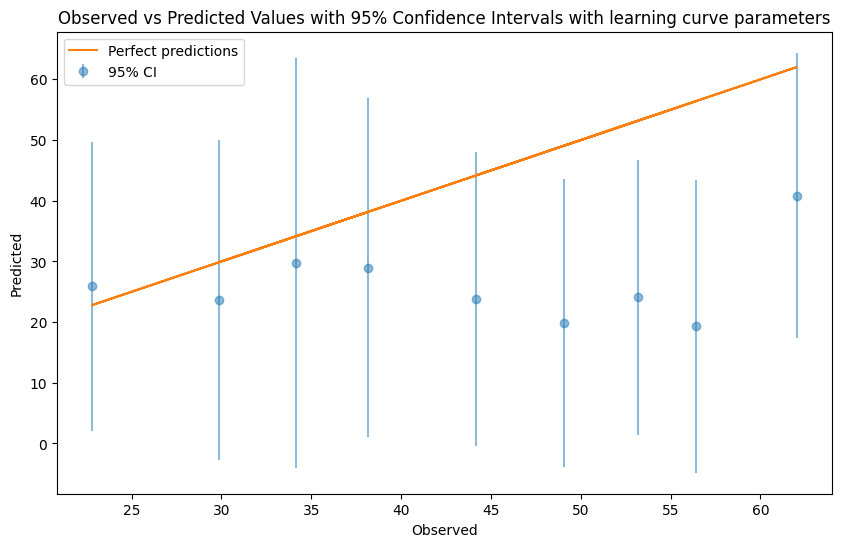

In [227]:
# Visualize the outcomes
plt.figure(figsize=(10, 6))

# Plot the observed vs predicted values with confidence intervals
plt.errorbar(y_test, y_pred_ols, yerr=1.96*pred_stderr, fmt='o', alpha=0.5, label='95% CI')

# Plot a line for perfect predictions
plt.plot(y_test, y_test, label='Perfect predictions')

# Labelling
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs Predicted Values with 95% Confidence Intervals with learning curve parameters')
plt.legend()
plt.show()

### Machine Learning Methods

In [228]:
# Re-defining the models dictionary
models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}

# Re-running the evaluation for each model
model_mse = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring=mse_scorer)
    mean_score = -np.mean(scores)
    model_mse[model_name] = mean_score

model_importances = {}
mse_details = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features_importance = dict(zip(X.columns, importances))
        sorted_importances = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)
        model_importances[model_name] = sorted_importances
    else:
        model_importances[model_name] = "This model doesn't support feature importance."

    mse_details[model_name] = {"Train MSE": train_mse, "Test MSE": test_mse}
    # Append to mse_list with the specified structure
    mse_entry = {
        'name': f"SEFL_WITH_PARA",  # Combine "SEFL_WITHOUT" with the model name
        'method': model_name,  # You might adjust this as needed
        'mse': test_mse
    }
    mse_list.append(mse_entry)

model_mse, model_importances, mse_details

({'Decision Tree Regressor': 272.46508,
  'Random Forest Regressor': 171.6649960395555,
  'Gradient Boosting Regressor': 210.18891733334036},
 {'Decision Tree Regressor': [('freezing_recall3', 0.7060509430847722),
   ('date_recall4', 0.12901202875972978),
   ('freezing_sefla', 0.0646286865630647),
   ('beta_1', 0.033073185580134334),
   ('freezing_seflb', 0.031039750553807918),
   ('freezing_recall2', 0.02244955293608848),
   ('freezing_recall1', 0.012575191190416881),
   ('date_recall1', 0.0011476016615491389),
   ('sex', 2.3059670436467807e-05),
   ('date_seflb', 0.0),
   ('date_recall2', 0.0),
   ('date_recall3', 0.0),
   ('age_selfa', 0.0)],
  'Random Forest Regressor': [('freezing_recall3', 0.4347307430627006),
   ('freezing_sefla', 0.16059776396536016),
   ('freezing_seflb', 0.09553484987537986),
   ('freezing_recall1', 0.0909478050670407),
   ('freezing_recall2', 0.08613692085734959),
   ('beta_1', 0.06081254097845889),
   ('date_recall3', 0.021478954304252465),
   ('date_recall

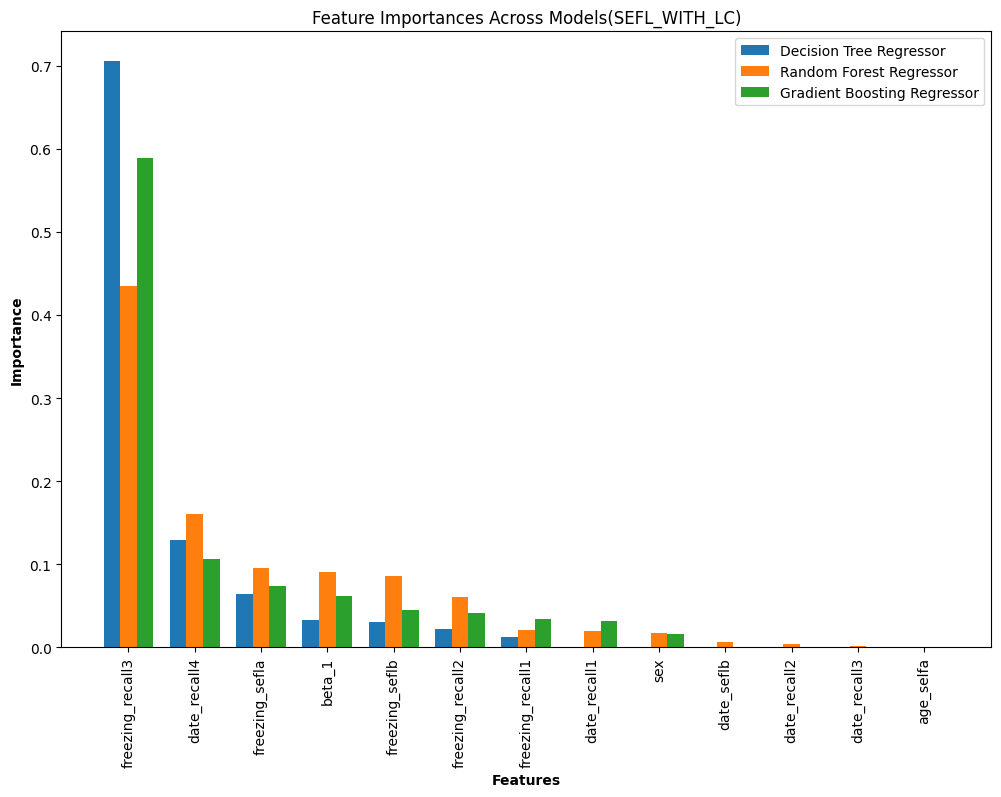

In [229]:
# Filter out models that don't support feature importance
valid_importances = {model: features for model, features in model_importances.items() if not isinstance(features, str)}

# Assuming all models have the same number and order of features, which should be ensured beforehand
feature_names = [feature for feature, _ in next(iter(valid_importances.values()))]

# Number of models and features
n_models = len(valid_importances)
n_features = len(feature_names)

# Creating a bar width and positions
barWidth = 1 / (n_models + 1)
positions = np.arange(n_features)

# Create figure and axis
plt.figure(figsize=(12, 8))

for i, (model_name, importances) in enumerate(valid_importances.items()):
    # Assuming the order of features is consistent across models, extract just the importances
    feature_importances = [importance for _, importance in importances]
    # Calculate position for each bar
    barPositions = [x + (i * barWidth) for x in positions]

    # Plot
    plt.bar(barPositions, feature_importances, width=barWidth, label=model_name)

# Adding labels and title
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Importance', fontweight='bold')
plt.title('Feature Importances Across Models(SEFL_WITH_LC)')

# Adding ticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(n_features)], feature_names, rotation=90)

# Create legend & Show graphic
plt.legend()
plt.show()

In [230]:
# Initialize and fit the XGBoost model with limited number of trees to avoid timeout
from xgboost import XGBRegressor
xgb_model_limited = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model_limited.fit(X, y)

# Extracting feature importances from the limited model
feature_importances_limited = xgb_model_limited.feature_importances_
features = X.columns
feature_importance_dict_limited = {feature: importance for feature, importance in zip(features, feature_importances_limited)}

# Sorting features by importance
sorted_feature_importance_limited = sorted(feature_importance_dict_limited.items(), key=lambda x: x[1], reverse=True)

sorted_feature_importance_limited

[('freezing_recall1', 0.41978925),
 ('beta_1', 0.19823001),
 ('freezing_recall3', 0.17743),
 ('freezing_recall2', 0.1132719),
 ('freezing_seflb', 0.05874062),
 ('freezing_sefla', 0.02348977),
 ('date_recall4', 0.0036633401),
 ('date_recall1', 0.0035016937),
 ('age_selfa', 0.001202144),
 ('date_recall2', 0.00035628755),
 ('sex', 0.00032493824),
 ('date_seflb', 0.0),
 ('date_recall3', 0.0)]

In [231]:
# 初始化XGBoost回归器模型
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=100)

# 训练模型
xgb_reg.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = xgb_reg.predict(X_test)

# 计算MSE
mse = mean_squared_error(y_test, y_pred)
print(f"testMSE: {mse}")

testMSE: 330.0830498891879


# Control Group


In [232]:
### test_1 is the first machine learning experiment
test_1 = data.copy()
# test_1.drop(columns=['freezing_recall5','date_recall5','dob','date_sefla','Unnamed: 0'], inplace = True)
test_1_control = test_1[test_1['condition']=='control']
test_1_control = test_1_control.drop(['condition','Unnamed: 0'], axis=1)
test_1_control['sex'] = test_1_control['sex'].replace({'male': 1, 'female': 0})
test_1_control['age_selfa'].astype(int)
test_1_control['age_selfa'] = (test_1_control['age_selfa'] > 84).astype(int)
test_1_control = test_1_control.drop(columns = ['dob','date_sefla'])

## Visualization Part

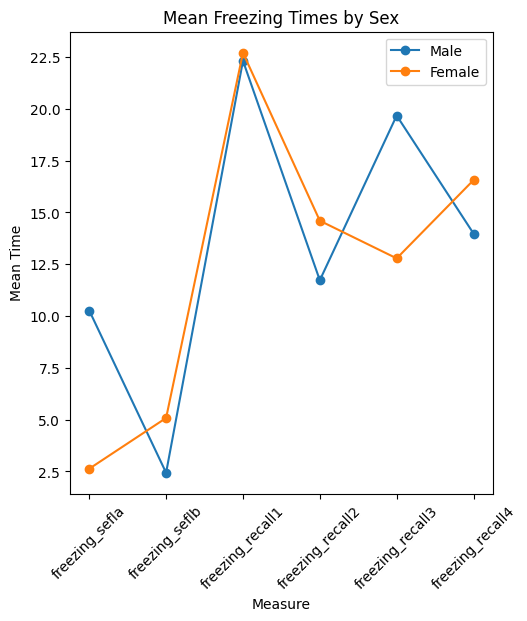

In [233]:
df = test_1_control.copy()
# Recalculating with inclusion of freezing sefla and freezing seflb
# For both sex and age groups
# Adding to the original calculation for comparison

# Recalculate means for sex categories
male_means = df[df['sex'] == 1][['freezing_sefla', 'freezing_seflb', 'freezing_recall1', 'freezing_recall2', 'freezing_recall3', 'freezing_recall4']].mean()
female_means = df[df['sex'] == 0][['freezing_sefla', 'freezing_seflb', 'freezing_recall1', 'freezing_recall2', 'freezing_recall3', 'freezing_recall4']].mean()

# Plotting
plt.figure(figsize=(12, 6))

# Sex
plt.subplot(1, 2, 2)
plt.plot(male_means.index, male_means.values, label='Male', marker='o')
plt.plot(female_means.index, female_means.values, label='Female', marker='o')
plt.title('Mean Freezing Times by Sex')
plt.xlabel('Measure')
plt.ylabel('Mean Time')
plt.xticks(rotation=45)
plt.legend()

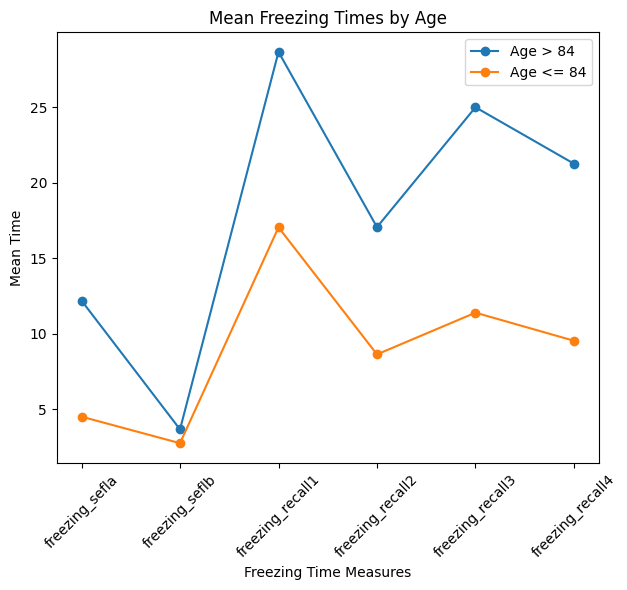

In [234]:
# Calculating mean freezing times for age above 100 and below or equal to 100
age_above_84_means = df[df['age_selfa']==1][['freezing_sefla', 'freezing_seflb', 'freezing_recall1', 'freezing_recall2', 'freezing_recall3', 'freezing_recall4']].mean()
age_below_84_means = df[df['age_selfa']==0][['freezing_sefla', 'freezing_seflb', 'freezing_recall1', 'freezing_recall2', 'freezing_recall3', 'freezing_recall4']].mean()
# Plotting
plt.figure(figsize=(12, 6))
# Plot for age
plt.subplot(1, 2, 2)
plt.plot(age_above_84_means, label='Age > 84', marker='o')
plt.plot(age_below_84_means, label='Age <= 84', marker='o')
plt.title('Mean Freezing Times by Age')
plt.xlabel('Freezing Time Measures')
plt.ylabel('Mean Time')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [235]:
test_1_control = test_1_control.drop(columns = ['freezing_recall5','date_recall5'])
test_1_control.dropna(inplace=True)

## Training without learning curve

In [236]:
from sklearn.model_selection import train_test_split
X = test_1_control.drop(columns = ['cohort_id','date_recall1','freezing_recall4'])
y = test_1_control['freezing_recall4']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### OLS

In [237]:
import statsmodels.api as sm

# Adding a constant to the X_train and X_test for the intercept term
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Creating the model
ols_model = sm.OLS(y_train, X_train_sm)

# Fitting the model
ols_results = ols_model.fit()

# Calculate MSE for training data
y_train_pred = ols_results.predict(X_train_sm)
mse_train = sm.tools.eval_measures.mse(y_train, y_train_pred)

# Calculate MSE for test data
y_test_pred = ols_results.predict(X_test_sm)
mse_test = sm.tools.eval_measures.mse(y_test, y_test_pred)

# Getting a summary of the model
ols_summary = ols_results.summary()
ols_summary, mse_train, mse_test

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:       freezing_recall4   R-squared:                       0.842
 Model:                            OLS   Adj. R-squared:                  0.684
 Method:                 Least Squares   F-statistic:                     5.334
 Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00706
 Time:                        03:55:07   Log-Likelihood:                -60.606
 No. Observations:                  21   AIC:                             143.2
 Df Residuals:                      10   BIC:                             154.7
 Df Model:                          10                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [238]:

mse_con_without_test = sm.tools.eval_measures.mse(y_test, y_test_pred)

# Dictionary for the first model's MSE and identifiers
mse_con_without = {
    'name': 'CON_WITHOUT',  # Model or group name
    'method': 'OLS',       # Method used
    'mse': mse_con_without_test  # Calculated MSE
}

# Append this dictionary to the list
mse_list.append(mse_con_without)

### Machine Learning Methods

In [239]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}


model_mse = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring=mse_scorer)
    mean_score = -np.mean(scores)
    model_mse[model_name] = mean_score

model_mse

{'Decision Tree Regressor': 242.4816846666667,
 'Random Forest Regressor': 90.56664029953336,
 'Gradient Boosting Regressor': 162.19576252940323}

In [240]:
model_importances = {}
mse_details = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features_importance = dict(zip(X.columns, importances))
        sorted_importances = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)
        model_importances[model_name] = sorted_importances
    else:
        model_importances[model_name] = "This model doesn't support feature importance."
        # Append to mse_list with the specified structure
    mse_entry = {
        'name': "CON_WITHOUT",  # Combine "SEFL_WITHOUT" with the model name
        'method': model_name,  # You might adjust this as needed
        'mse': test_mse
    }
    mse_list.append(mse_entry)

    mse_details[model_name] = {"Train MSE": train_mse, "Test MSE": test_mse}

for model_name, importances in model_importances.items():
    mse_info = mse_details[model_name]
    print(f"{model_name} MSE:")
    print(f"Train MSE: {mse_info['Train MSE']}")
    print(f"Test MSE: {mse_info['Test MSE']}\n")
    print(f"{model_name} feature importances:")
    for feature, importance in importances:
        print(f"{feature}: {importance}")
    print("\n")

Decision Tree Regressor MSE:
Train MSE: 0.0
Test MSE: 103.15770000000002

Decision Tree Regressor feature importances:
freezing_recall3: 0.6577039562254573
freezing_sefla: 0.24396850867966174
freezing_seflb: 0.07496209460656228
freezing_recall1: 0.020942770569519445
date_recall3: 0.0016444664960545573
freezing_recall2: 0.0007522952939974853
date_recall4: 2.590812874730113e-05
date_seflb: 0.0
date_recall2: 0.0
sex: 0.0
age_selfa: 0.0


Random Forest Regressor MSE:
Train MSE: 12.96439069285718
Test MSE: 69.88424016500002

Random Forest Regressor feature importances:
freezing_recall3: 0.47767754308850063
freezing_sefla: 0.3040242240535301
freezing_recall1: 0.076681175326491
freezing_seflb: 0.07148798032705278
freezing_recall2: 0.05466986224173866
age_selfa: 0.0038348157501408063
sex: 0.00321674514552017
date_recall4: 0.003022157670935573
date_recall3: 0.0027398064851736014
date_recall2: 0.002645689910916781
date_seflb: 0.0


Gradient Boosting Regressor MSE:
Train MSE: 0.001819261412246336

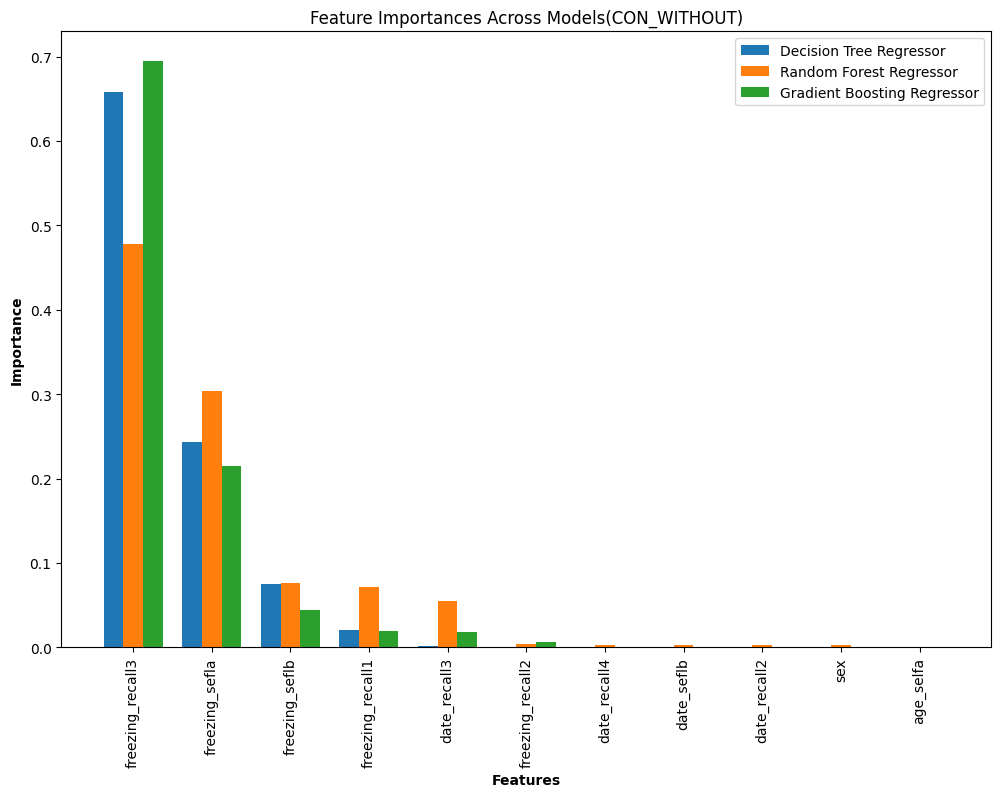

In [241]:
# Filter out models that don't support feature importance
valid_importances = {model: features for model, features in model_importances.items() if not isinstance(features, str)}

# Assuming all models have the same number and order of features, which should be ensured beforehand
feature_names = [feature for feature, _ in next(iter(valid_importances.values()))]

# Number of models and features
n_models = len(valid_importances)
n_features = len(feature_names)

# Creating a bar width and positions
barWidth = 1 / (n_models + 1)
positions = np.arange(n_features)

# Create figure and axis
plt.figure(figsize=(12, 8))

for i, (model_name, importances) in enumerate(valid_importances.items()):
    # Assuming the order of features is consistent across models, extract just the importances
    feature_importances = [importance for _, importance in importances]
    # Calculate position for each bar
    barPositions = [x + (i * barWidth) for x in positions]

    # Plot
    plt.bar(barPositions, feature_importances, width=barWidth, label=model_name)

# Adding labels and title
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Importance', fontweight='bold')
plt.title('Feature Importances Across Models(CON_WITHOUT)')

# Adding ticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(n_features)], feature_names, rotation=90)

# Create legend & Show graphic
plt.legend()
plt.show()

##Training with learning curve parameters


In [242]:
test_control_lc = test_1_control.merge(df_all_lc, on='cohort_id', how='inner')

In [243]:
from sklearn.linear_model import LinearRegression

# Preparing the independent variable (1 to 10)
X_lc = np.array(range(1, 11)).reshape(-1, 1)

# Placeholder for calculated beta_1 values
beta_1_values = []

# Loop through each row to calculate beta_1 for Shock01 to Shock10
for index, row in test_control_lc.iterrows():
    y = row[['Shock01', 'Shock02', 'Shock03', 'Shock04', 'Shock05',
             'Shock06', 'Shock07', 'Shock08', 'Shock09', 'Shock10']].values.reshape(-1, 1)
    model = LinearRegression().fit(X_lc, y)
    beta_1 = model.coef_[0][0]  # Extracting beta_1 (slope)
    beta_1_values.append(beta_1)

# Adding the beta_1 values as a new column to the dataframe
test_control_lc['beta_1'] = beta_1_values

# Dropping the original Shock columns
test_control_lc_para = test_control_lc.drop(columns=['Shock01', 'Shock02', 'Shock03', 'Shock04', 'Shock05',
                                  'Shock06', 'Shock07', 'Shock08', 'Shock09', 'Shock10'])

# Showing the modified dataframe
test_control_lc_para.head()

,cohort_id,freezing_sefla,freezing_seflb,date_seflb,freezing_recall1,date_recall1,freezing_recall2,date_recall2,freezing_recall3,date_recall3,freezing_recall4,date_recall4,sex,age_selfa,beta_1
0,ptsd2_81,5.03,0.45,1,8.28,2,7.12,5,7.57,7,6.61,21.0,1,0,-0.041939
1,ptsd2_82,8.83,4.20,1,28.80,2,11.14,5,3.22,7,2.24,21.0,1,0,0.665636
2,ptsd2_91,2.60,2.73,1,14.97,2,11.68,5,9.80,7,7.30,21.0,1,0,0.016061
3,ptsd2_92,1.91,2.53,1,14.42,2,3.11,5,2.94,7,14.89,21.0,1,0,-0.148667
4,ptsd3_2,6.15,1.72,1,19.43,2,14.30,5,18.87,7,11.77,16.0,1,1,0.944485


### OLS

In [244]:
# Prepare the independent variables (X) by dropping the dependent variable and the identifier
X = test_control_lc_para.drop(columns=['cohort_id', 'freezing_recall4'])
# Adding a constant for the intercept
X = sm.add_constant(X)

# Prepare the dependent variable (y)
y = test_control_lc_para['freezing_recall4']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [245]:
# Perform OLS regression
model = sm.OLS(y, X).fit()

# Get the summary of the regression
model_summary = model.summary()

model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       freezing_recall4   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     5.813
Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00132
Time:                        03:55:09   Log-Likelihood:                -77.361
No. Observations:                  27   AIC:                             180.7
Df Residuals:                      14   BIC:                             197.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
freezing_sefla       0.1002      0.289      0.346      0.734      -0.520       0.721
freezing_seflb      -0.7353      0.456     -1.614      0.129      -1.712       0.242
date_seflb          36.0842     11.097      3.252      0.006      12.283      59.886
freezing_recall1    -0.1268      0.164     -0.773      0.452      -0.479       0.225
date_recall1         3.0016      3.960      0.758      0.461      -5.493      11.496
freezing_recall2    -0.1535      0.205     -0.747      0.467      -0.594       0.287
date_recall2        -6.8124      5.654     -1.205      0.248     -18.940       5.315
freezing_recall3     0.4430      0.130      3.413      0.004       0.165       0.721
date_recall3         1.3487      1.319      1.023      0.324      -1.480       4.177
date_recall4         1.1621      1.000      1.162      0.265      -0.983       3.307
sex                -32.1962      9.866     -3.263      0.006     -53.356     -11.036
age_selfa            3.1675      5.938      0.533      0.602      -9.568      15.903
beta_1               1.7703      1.525      1.161      0.265      -1.501       5.042
==============================================================================
Omnibus:                        2.789   Durbin-Watson:                   2.551
Prob(Omnibus):                  0.248   Jarque-Bera (JB):                2.450
Skew:                           0.688   Prob(JB):                        0.294
Kurtosis:                       2.466   Cond. No.                         604.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [246]:
# Fit OLS model
ols_model = OLS(y_train, sm.add_constant(X_train)).fit()

# Get OLS predictions for the test set
y_pred_ols = ols_model.predict(sm.add_constant(X_test))

# Get standard errors of predictions
pred_stderr = ols_model.get_prediction(sm.add_constant(X_test)).se_obs

# Calculate the 95% confidence interval for the predictions
ci_lower = y_pred_ols - 1.96 * pred_stderr
ci_upper = y_pred_ols + 1.96 * pred_stderr

# Checking how many of the actual test values fall within the 95% confidence interval
inside_ci = np.sum((y_test >= ci_lower) & (y_test <= ci_upper))
percentage_inside_ci = (inside_ci / len(y_test)) * 100

percentage_inside_ci

100.0

In [247]:
mse_con_with_test = sm.tools.eval_measures.mse(y_test, y_pred_ols)

# Dictionary for the first model's MSE and identifiers
mse_con_with = {
    'name': 'CON_WITH_PARA',  # Model or group name
    'method': 'OLS',       # Method used
    'mse': mse_con_with_test  # Calculated MSE
}

# Append this dictionary to the list
mse_list.append(mse_con_with)

### Machine Learning Methods

In [248]:
# Re-defining the models dictionary
models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}

# Re-running the evaluation for each model
model_mse = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring=mse_scorer)
    mean_score = -np.mean(scores)
    model_mse[model_name] = mean_score

model_importances = {}
mse_details = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features_importance = dict(zip(X.columns, importances))
        sorted_importances = sorted(features_importance.items(), key=lambda x: x[1], reverse=True)
        model_importances[model_name] = sorted_importances
    else:
        model_importances[model_name] = "This model doesn't support feature importance."

    mse_details[model_name] = {"Train MSE": train_mse, "Test MSE": test_mse}

    mse_entry = {
        'name': f"CON_WITH_PARA",  # Combine "SEFL_WITHOUT" with the model name
        'method': model_name,  # You might adjust this as needed
        'mse': test_mse
    }
    mse_list.append(mse_entry)

model_mse, model_importances, mse_details

({'Decision Tree Regressor': 233.30635266666667,
  'Random Forest Regressor': 96.1207558342667,
  'Gradient Boosting Regressor': 131.97505517632058},
 {'Decision Tree Regressor': [('freezing_recall3', 0.6493345378074677),
   ('beta_1', 0.27491862093914476),
   ('freezing_recall2', 0.04982781083456733),
   ('freezing_sefla', 0.018855686883190587),
   ('date_recall1', 0.0029645682845383177),
   ('freezing_seflb', 0.0027413772186264153),
   ('freezing_recall1', 0.0013300305723915494),
   ('date_recall4', 2.736746007339694e-05),
   ('date_seflb', 0.0),
   ('date_recall2', 0.0),
   ('date_recall3', 0.0),
   ('sex', 0.0),
   ('age_selfa', 0.0)],
  'Random Forest Regressor': [('freezing_recall3', 0.4856435248198035),
   ('freezing_sefla', 0.1819538213885723),
   ('beta_1', 0.1095015658957177),
   ('freezing_recall1', 0.09547280221789543),
   ('freezing_recall2', 0.05818382993126367),
   ('freezing_seflb', 0.05341004878823032),
   ('sex', 0.0048215226994077),
   ('date_recall1', 0.003193732061

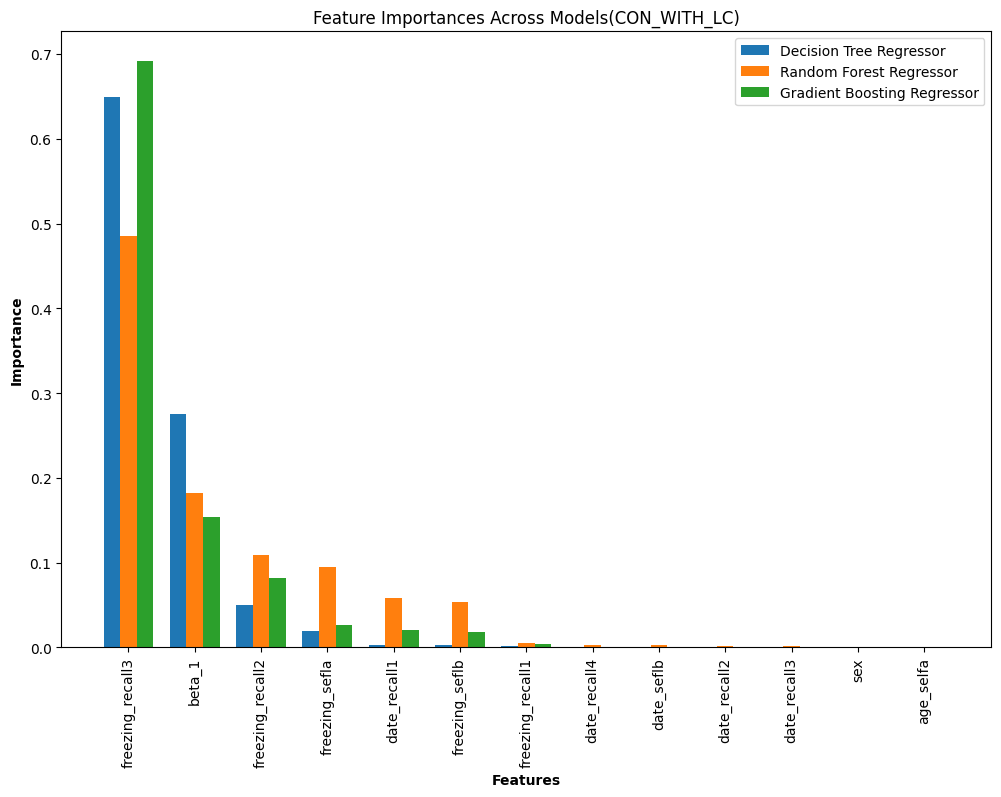

In [249]:
# Filter out models that don't support feature importance
valid_importances = {model: features for model, features in model_importances.items() if not isinstance(features, str)}

# Assuming all models have the same number and order of features, which should be ensured beforehand
feature_names = [feature for feature, _ in next(iter(valid_importances.values()))]

# Number of models and features
n_models = len(valid_importances)
n_features = len(feature_names)

# Creating a bar width and positions
barWidth = 1 / (n_models + 1)
positions = np.arange(n_features)

# Create figure and axis
plt.figure(figsize=(12, 8))

for i, (model_name, importances) in enumerate(valid_importances.items()):
    # Assuming the order of features is consistent across models, extract just the importances
    feature_importances = [importance for _, importance in importances]
    # Calculate position for each bar
    barPositions = [x + (i * barWidth) for x in positions]

    # Plot
    plt.bar(barPositions, feature_importances, width=barWidth, label=model_name)

# Adding labels and title
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Importance', fontweight='bold')
plt.title('Feature Importances Across Models(CON_WITH_LC)')

# Adding ticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(n_features)], feature_names, rotation=90)

# Create legend & Show graphic
plt.legend()
plt.show()

# Visualization of all results

In [250]:
mse_df = pd.DataFrame(mse_list)
mse_df

,name,method,mse
0,SEFL_WITHOUT,OLS,210.809056
1,SEFL_WITHOUT,Decision Tree Regressor,248.619300
2,SEFL_WITHOUT,Random Forest Regressor,252.835014
3,SEFL_WITHOUT,Gradient Boosting Regressor,276.158120
4,SEFL_WITH_PARA,OLS,454.530979
5,SEFL_WITH_PARA,Decision Tree Regressor,322.673500
6,SEFL_WITH_PARA,Random Forest Regressor,374.543277
7,SEFL_WITH_PARA,Gradient Boosting Regressor,406.255369
8,CON_WITHOUT,OLS,37.590106
9,CON_WITHOUT,Decision Tree Regressor,103.157700


<ipython-input-251-3e28a3da4bf1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=mse_df, x='mse', y='method', inner='stick', palette='colorblind')


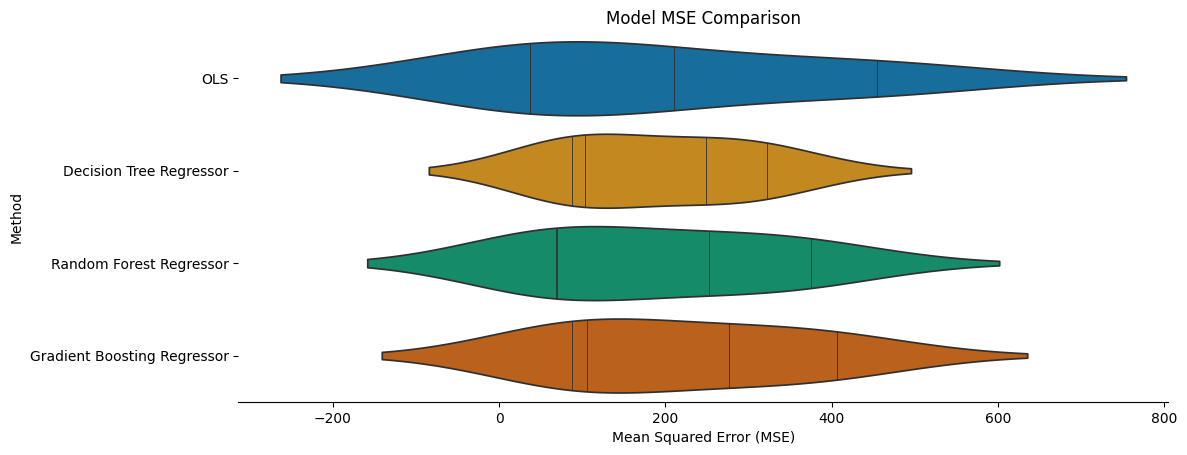

In [251]:
figsize = (12, 1.2 * len(mse_df['method'].unique()))
plt.figure(figsize=figsize)

# Using the 'colorblind' palette
sns.violinplot(data=mse_df, x='mse', y='method', inner='stick', palette='colorblind')
sns.despine(top=True, right=True, left=True)

# Optional: Adding more descriptive title and labels
plt.title('Model MSE Comparison')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Method')

plt.show()

<ipython-input-252-44c05a3b8511>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtered, x='method', y='mse', palette='colorblind')
<ipython-input-252-44c05a3b8511>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtered, x='method', y='mse', palette='colorblind')
<ipython-input-252-44c05a3b8511>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtered, x='method', y='mse', palette='colorblind')
<ipython-input-252-44c05a3b8511>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

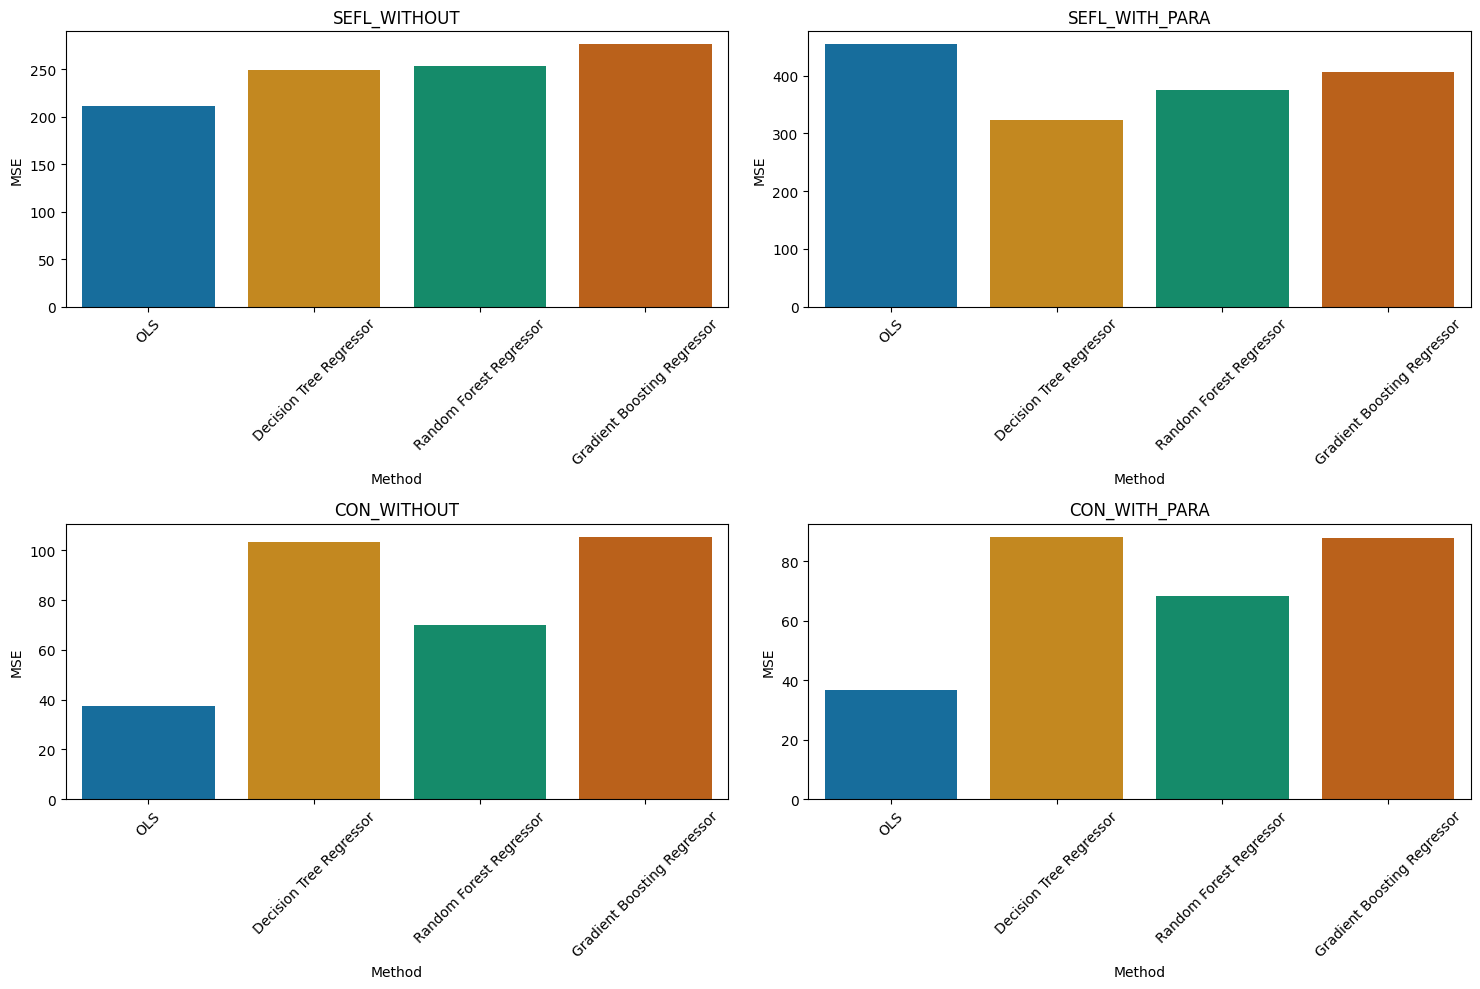

In [252]:
plt.figure(figsize=(15, 10))

for i, name in enumerate(mse_df['name'].unique()):
    plt.subplot(2, 2, i+1)
    df_filtered = mse_df[mse_df['name'] == name]
    sns.barplot(data=df_filtered, x='method', y='mse', palette='colorblind')
    plt.title(name)
    plt.xticks(rotation=45)
    plt.ylabel('MSE')
    plt.xlabel('Method')

plt.tight_layout()